In [1]:
!pip install pydub


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from pydub import AudioSegment
from pydub.generators import Sine, Square, Sawtooth
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/Neww/images.npy'
data = np.load(file_path)

Using device: cuda
Enter the index of the image (e.g., 6): 6


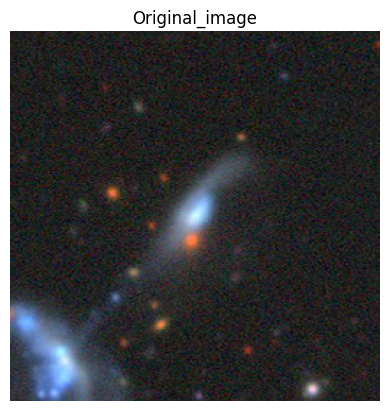

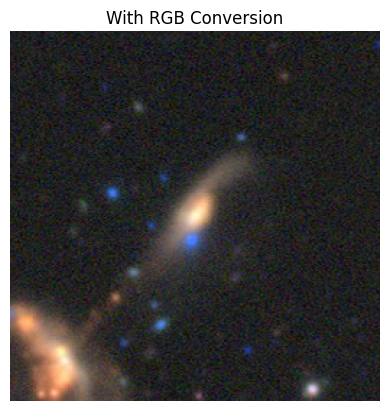

Pixel data saved to galaxy_image_pixel_data.csv
Select a sonification mode:
1. Color-Based Sound Effects
2. Pitch Mapping Based on Brightness
3. Frequency Mapping
4. HSV Mapping
Enter the mode number (1, 2, 3, or 4): 3
WAV file saved at: output_sound_1000_rows_frequency_mapping.wav


In [6]:
# Device setting for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def pixel_extraction(image_index):
    image = data[image_index]

    # Display the original image
    plt.imshow(image)
    plt.title('Original_image')
    plt.axis('off')
    plt.show()

    # Convert to RGB format (if needed)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the RGB image
    plt.imshow(rgb_image)
    plt.title('With RGB Conversion')
    plt.axis('off')
    plt.show()

    return image, rgb_image

def save_pixel_data(image, filename='galaxy_image_pixel_data.csv'):
    height, width, channels = image.shape
    pixel_data = image.reshape(height * width, channels)
    df = pd.DataFrame(pixel_data, columns=['R', 'G', 'B'])
    df.to_csv(filename, index=False)
    print(f'Pixel data saved to {filename}')

def brightness(r, g, b):
    return 0.299 * r + 0.587 * g + 0.114 * b

def brightness_to_pitch(brightness):
    return 220 + (brightness / 255.0) * 660

def rgb_to_sound(r, g, b, duration=100):
    pitch = brightness_to_pitch(brightness(r, g, b))

    if r > g and r > b:
        tone = Sine(pitch).to_audio_segment(duration=duration)
    elif g > r and g > b:
        tone = Square(pitch).to_audio_segment(duration=duration)
    else:
        tone = Sawtooth(pitch).to_audio_segment(duration=duration)

    return tone

def color_based_sound_effects(image):
    # Generate sound wave based on color
    pixels = np.array(image)
    sample_rate = 44100
    duration = 0.5  # seconds per pixel row
    wave = []

    for row in pixels:
        red = row[:, 0].mean() / 255.0
        green = row[:, 1].mean() / 255.0
        blue = row[:, 2].mean() / 255.0

        t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
        wave_row = 0.5 * (red * np.sin(2 * np.pi * 440 * t) + green * np.sin(2 * np.pi * 660 * t) + blue * np.sin(2 * np.pi * 880 * t))
        wave.extend(wave_row)

    return np.array(wave), sample_rate

def map_frequency(value, min_freq, max_freq, offset):
    return offset + (value / 255.0) * (max_freq - min_freq)

def generate_audio_from_rgb(rgb_data, duration_ms=100):
    audio = AudioSegment.silent(duration=0)  # Initialize an empty audio segment

    # Defining frequency ranges
    rgb_frequency_range = {
        'r': {'min': 30, 'max': 500, 'offset': 60},
        'g': {'min': 500, 'max': 2000, 'offset': 250},
        'b': {'min': 2000, 'max': 10000, 'offset': 1000},
    }

    # Generate sine waves for each RGB value
    for _, row in rgb_data.iterrows():
        freq_r = map_frequency(row['R'], rgb_frequency_range['r']['min'], rgb_frequency_range['r']['max'], rgb_frequency_range['r']['offset'])
        freq_g = map_frequency(row['G'], rgb_frequency_range['g']['min'], rgb_frequency_range['g']['max'], rgb_frequency_range['g']['offset'])
        freq_b = map_frequency(row['B'], rgb_frequency_range['b']['min'], rgb_frequency_range['b']['max'], rgb_frequency_range['b']['offset'])

        sine_r = Sine(freq_r).to_audio_segment(duration=duration_ms, volume=row['R'] / 255 * 20 - 20)
        sine_g = Sine(freq_g).to_audio_segment(duration=duration_ms, volume=row['G'] / 255 * 20 - 20)
        sine_b = Sine(freq_b).to_audio_segment(duration=duration_ms, volume=row['B'] / 255 * 20 - 20)

        # Combine the sine waves for R, G, and B into a single segment
        combined = sine_r.overlay(sine_g).overlay(sine_b)
        audio += combined  # Append to the audio segment

    return audio

def rgb_to_hsv(r, g, b):
    return colorsys.rgb_to_hsv(r / 255.0, g / 255.0, b / 255.0)

def hue_to_frequency(hue):
    # Map hue (0-1) to frequency (220-880 Hz)
    return 220 + hue * 660

def saturation_to_amplitude(saturation):
    # Map saturation (0-1) to amplitude (0-1)
    return saturation

def value_to_duration(value):
    # Map value (0-1) to duration (100-500 ms)
    return 100 + value * 400

def hsv_to_sound(hue, saturation, value):
    frequency = hue_to_frequency(hue)
    amplitude = saturation_to_amplitude(saturation)
    duration = value_to_duration(value)
    # Generate sine wave with the calculated frequency and amplitude
    tone = Sine(frequency).to_audio_segment(duration=duration).apply_gain(amplitude * 20 - 20)
    return tone

def generate_audio_from_hsv(rgb_data):
    audio = AudioSegment.silent(duration=0)

    for index, row in rgb_data.iterrows():
        r, g, b = row['R'], row['G'], row['B']
        hue, saturation, value = rgb_to_hsv(r, g, b)
        tone = hsv_to_sound(hue, saturation, value)
        audio += tone

    return audio

def save_wave_to_file(wave, sample_rate, filename='output_sound.wav'):
    sf.write(filename, wave, sample_rate)
    print(f"Sound file saved as {filename}")

def save_audio_segment_to_file(audio, filename='output_sound.wav'):
    audio.export(filename, format="wav")
    print(f"WAV file saved at: {filename}")

def main():
    image_index = int(input("Enter the index of the image (e.g., 6): "))
    image, rgb_image = pixel_extraction(image_index)
    save_pixel_data(image)

    print("Select a sonification mode:")
    print("1. Color-Based Sound Effects")
    print("2. Pitch Mapping Based on Brightness")
    print("3. Frequency Mapping")
    print("4. HSV Mapping")
    mode = int(input("Enter the mode number (1, 2, 3, or 4): "))

    if mode == 1:
        wave, sample_rate = color_based_sound_effects(image)
        save_wave_to_file(wave, sample_rate)
    elif mode == 2:
        df = pd.read_csv('galaxy_image_pixel_data.csv')
        df_subset = df.head(1000)

        r_tensor = torch.tensor(df_subset['R'].values, dtype=torch.float32).to(device)
        g_tensor = torch.tensor(df_subset['G'].values, dtype=torch.float32).to(device)
        b_tensor = torch.tensor(df_subset['B'].values, dtype=torch.float32).to(device)

        audio = AudioSegment.silent(duration=0)
        for r, g, b in zip(r_tensor, g_tensor, b_tensor):
            tone = rgb_to_sound(r.item(), g.item(), b.item())
            audio += tone

        output_filename = "output_sound_1000_rows_pitch_mapping.wav"
        save_audio_segment_to_file(audio, output_filename)

    elif mode == 3:
        df = pd.read_csv('galaxy_image_pixel_data.csv')
        df_subset = df.head(1000)
        audio = generate_audio_from_rgb(df_subset, duration_ms=100)
        output_filename = "output_sound_1000_rows_frequency_mapping.wav"
        save_audio_segment_to_file(audio, output_filename)

    elif mode == 4:
        df = pd.read_csv('galaxy_image_pixel_data.csv')
        df_subset = df.head(1000)
        audio = generate_audio_from_hsv(df_subset)
        output_filename = "output_sound_1000_rows_hsv_mapping.wav"
        save_audio_segment_to_file(audio, output_filename)

    else:
        print("Invalid mode selected.")

if __name__ == "__main__":
    main()
